## fMRI noise estimation and signal combination

1. Estimate fMRI noise parameters from existing data
2. Generate noise for every voxel given the estimated parameters
3. Combine estimated voxel responses with noise 
4. Convolve each voxel’s time course with the HRF
5. Establish 'true' signal magnitude

The fMRI noise estimation procedure follows closely the approach described in 

    Ellis, C., Baldassano, C., Schapiro, A. C., Cai, M. B., & Cohen, J. D. (2019). Facilitating open-science with realistic fMRI simulation: validation and application. BioRxiv.
    
also see

    https://github.com/brainiak/brainiak/blob/master/examples/utils/fmrisim_multivariate_example.ipynb

In [ ]:
import os, sys
from brainiak.utils import fmrisim
from nilearn import image
from nilearn.image import load_img, new_img_like, index_img
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 1. Estimate fMRI noise parameters from existing data
Estimate fMRI noise parameters for a single subject: here we use 'Subject 07' who was one of two participants of the pilot for the main experiment.

In [10]:
# load paths for existing data
sys.path.append(os.path.join(os.path.dirname(os.getcwd())))
from flow import Paths
File, Folder = Paths.SubjectData('07')

Load raw EPI data (all acquired scans)

In [3]:
file_epi = File['Bold'][0]
i = load_img(file_epi)
dimsize = i.header.get_zooms()
volume = i.get_data()
# use only voxels corresponding to tissue
mask, template = fmrisim.mask_brain(volume=volume, mask_self=True)

The following description of the underlying noise estimation process is from https://github.com/brainiak/brainiak/blob/master/examples/utils/fmrisim_multivariate_example.ipynb

>A critical step in the fmrisim toolbox is determining the noise parameters of the volume to be created. Many noise parameters are available for specification and if any are not set then they will default to reasonable values. As mentioned before, it is instead possible to provide raw fMRI data that will be used to estimate these noise parameters. The goal of the noise estimation is to calculate general descriptive statistics about the noise in the brain that are thought to be important. The simulations are then useful for understanding how signals will survive analyses when embedded in realistic neural noise. 

> Now the disclaimers: the values here are only an estimate and will depend on noise properties combining in the ways assumed. In addition, because of the non-linearity and stochasticity of this simulation, this estimation is not fully invertible: if you generate a dataset with a set of noise parameters it will have similar but not the same noise parameters as a result. Moreover, complex interactions between brain regions that likely better describe brain noise are not modelled here: this toolbox pays no attention to regions of the brain or their interactions. Finally, for best results use raw fMRI because if the data has been preprocessed then assumptions this algorithm makes are likely to be erroneous. For instance, if the brain has been masked then this will eliminate variance in non-brain voxels which will mean that calculations of noise dependent on those voxels as a reference will fail.

> To ameliorate some of these concerns, it is possible to fit the spatial and temporal noise properties of the data. This iterates over the noise generation process and tunes parameters in order to match those that are provided. This is time consuming (especially for fitting the temporal noise) but is helpful in matching the specified noise properties. 

>This toolbox separates noise in two: spatial noise and temporal noise. To estimate spatial noise both the smoothness and the amount of non-brain noise of the data must be quantified. For smoothness, the Full Width Half Max (FWHM) of the volume is averaged for the X, Y and Z dimension and then averaged across a sample of time points. To calculate the Signal to Noise Ratio (SNR) the mean activity in brain voxels for the middle time point is divided by the standard deviation in activity across non-brain voxels for that time point. For temporal noise an auto-regressive and moving average (ARMA) process is estimated, along with the overall size of temporal variability. A sample of brain voxels is used to estimate the first AR component and the first MA component of each voxel's activity over time using the statsmodels package. The Signal to Fluctuation Noise Ratio (SFNR) is calculated by dividing the average activity of voxels in the brain with that voxel’s noise  (Friedman & Glover, 2006). That noise is calculated by taking the standard deviation of that voxel over time after it has been detrended with a second order polynomial. The SFNR then controls the amount of functional variability. Other types of noise can be generated, such as physiological noise, but are not estimated by this function.

In [ ]:
noise_dict = {'voxel_size': [dimsize[0], dimsize[1], dimsize[2]], 'matched': 1}
noise_dict = fmrisim.calc_noise(
    volume=volume,
    mask=mask,
    template=template,
    noise_dict=noise_dict
)
    
print('Noise parameters of the data were estimated as follows:')
print('SNR: ' + str(noise_dict['snr']))
print('SFNR: ' + str(noise_dict['sfnr']))
print('FWHM: ' + str(noise_dict['fwhm']))

### 2. Generate noise for every voxel given the estimated parameters

In [ ]:
# Calculate the noise given the parameters
noise = fmrisim.generate_noise(dimensions=dim[0:3],
                               tr_duration=int(tr),
                               stimfunction_tr=[0] * dim[3], 
                               mask=mask,
                               template=template,
                               noise_dict=noise_dict,
                               )

### 3. Combine estimated voxel responses with noise 

In [16]:
from sim import signal
# load experiment data and simulated responses
Folder, _, _, _ = Paths.ExpData()
file_seq = os.path.join(Folder['Bids'], 'sequences_individual.tsv')  # Import all sequences from CSV file.
Seq = pd.read_csv(file_seq).values  # load individual sequences
file_exp = os.path.join(Folder['Bids'], 's1_task.tsv')  # Import all sequences from CSV file.
T = pd.read_csv(file_exp, index_col=0)  # load individual sequences
    

sigma = 8
# timing params
TR = 1.206
fq = 10
hrf_lag = 10

# unit responses over exp
w = signal.unit_resp(Seq, sigma, T, TR, fq)

Plot the matrix of simulated unit respsonses over the experiment.  

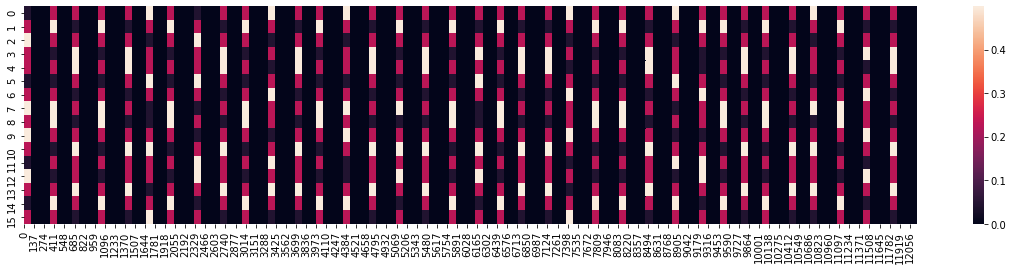

In [18]:
import seaborn as sns
fig = plt.figure(figsize=(20,4))
sns.heatmap(w.transpose());

### 4. Convolve each voxel’s time course with the HRF

With the time course of stimulus events it is necessary to estimate the brain’s response to those events, which can be estimated by convolving it with using a hemodynamic response function (HRF). By default, fmrisim.convolve_hrf assumes a double gamma HRF appropriately models a brain’s response to events, as modeled by fMRI (Friston, et al., 1998). To do this convolution, each voxel’s time course is convolved to make a function of the signal activity. Hence this produces an estimate of the voxel’s activity, after considering the temporal blurring of the HRF. This can take a single vector of events or multiple time courses.

In [ ]:
# Presentation events: onset is at the start of each trial, duration two scans per item i.e. 8 scans per sequence
y_func = fmrisim.convolve_hrf(
    stimfunction=w,
    tr_duration=TR,
    temporal_resolution=fq,
    scale_function=1
)

### 5. Establish signal magnitude

When specifying the signal we must determine the amount of activity change for each voxel. For instance, we can calculate percent signal change (referred to as PSC) by taking the average activity of a voxel in the noise volume and multiplying the maximal activation of the signal by a percentage of this number. This metric doesn't take into account the variance in the noise but other metrics do. One metric that does take account of variance, and is used below, is the signal amplitude divided by the temporal variability. Choices that are available for computing the signal scale are discussed in Welvaert and Rosseel (2013).

Here we use the following:
- 'CNR_Amp/Noise-SD': Signal magnitude relative to the temporal noise
- 'SFNR': Change proportional to the temporal variability, as represented by the SFNR

In [19]:
Scaling_Mag = [0.5, 0.15, 0.05]
Scaling_Met = ['CNR_Amp/Noise-SD', 'SFNR']

In [ ]:
y_func_scaled = fmrisim.compute_signal_change(
    y_func,
    noise_func,
    noise_dict,
    magnitude=[Scaling_Mag[0]],
    method=Scaling_Met[0]
)
y_bold = y_func_scaled.transpose() + noise_func